In [103]:
import datasets
from src.models.components.partmae_v4 import PARTMaskedAutoEncoderViT, PART_mae_vit_base_patch16_dec512d8b
from src.data.components.transforms.multi_crop_v2 import ParametrizedMultiCropV2
from lightning import Fabric
from tqdm import tqdm
from torch import nn, Tensor
import torch
from torch.utils.data import Dataset, DataLoader, default_collate
from torchmetrics import MeanSquaredError, MeanMetric, MetricCollection
from PIL import Image
from lightning.fabric.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import math
import timm
import timm.scheduler
import torch.optim
from omegaconf import OmegaConf
import hydra

## Overfit Training

In [104]:
img = Image.open("../../artifacts/samoyed.jpg").crop((0, 0, 1000, 1000))
gV = 1
lV = 5
train_transform = ParametrizedMultiCropV2(n_global_crops=gV, n_local_crops=lV)
batch = train_transform(img)
batch = [batch[i].unsqueeze(0) for i in range(len(batch))]

In [105]:
# overfit to a few batches
torch.set_float32_matmul_precision("high")

In [106]:
cfg = OmegaConf.load("../../artifacts/model-qjvoibpm:v0/config.yaml")

In [107]:
fabric = Fabric()
state = {
    "model": hydra.utils.instantiate(cfg["model"], verbose=True)
}
ckpt = fabric.load("../../artifacts/model-qjvoibpm:v0/epoch_0049.ckpt", state)
model = state["model"]
print(ckpt.keys())
print(ckpt["epoch"])

dict_keys(['optimizer', 'epoch', 'global_step', 'scheduler'])
49


## Reconstruction

### Utils

In [108]:
def clean_model_io(batch: tuple, out: dict, device="cuda"):
    """
    Cleans and reshapes model outputs for visualization.

    - Detach and move tensors to device.
    - Adds useful tensors to dict (crop_params, canonical_params)
    """
    io = dict()

    io["g_x"] = batch[0]
    io["g_params"] = batch[1]
    io["l_x"] = batch[2]
    io["l_params"] = batch[3]

    for pfx in ["g", "l"]:
        io[f"{pfx}_crop_params"] = io[f"{pfx}_params"][:, :, 4:8]  
    
    io[f"canonical_params"] = io[f"g_params"][:, 0, :4]

    io.update({name: out[name] for name in out.keys()})
    io["patch_positions_nopos"] = torch.cat(
        [out["g_patch_positions_nopos"], out["l_patch_positions_nopos"]], dim=1
    )
    # params = torch.cat([g_out["params"], l_out["params"]], dim=1)
    io["params"] = torch.cat(
        [io["g_params"], io["l_params"]], dim=1
    )
    io["crop_params"] = io["params"][:, :, 4:8]  # [bs, n_patches, 4]

    ## MOVE TO DEVICE and DETACH
    clean = lambda x: x.to(device).detach() if isinstance(x, Tensor) else x
    io = {name: clean(tensor) for name, tensor in io.items()}
    return io


In [109]:
from src.utils.visualization.reconstruction_v4_gt import (
    reconstruction_gt,
)

def make_plots(
    reconstructed_img: Tensor, io: dict, batch_idx: int, original_img: Image.Image
):
    gt_reconstruction = reconstruction_gt(
        g_crops=io["g_x"][batch_idx],
        l_crops=io["l_x"][batch_idx],
        g_patch_positions_nopos=io["g_patch_positions_nopos"][batch_idx],
        l_patch_positions_nopos=io["l_patch_positions_nopos"][batch_idx],
        patch_size=16,
        canonical_img_size=512,
        g_shapes=io["g_shapes"],
        l_shapes=io["l_shapes"],
        g_crop_params=io["g_crop_params"][batch_idx],
        l_crop_params=io["l_crop_params"][batch_idx],
    )
    fig, axes = plt.subplots(1, 3)
    canonical_img = train_transform.recreate_canonical(
        original_img, io["canonical_params"][batch_idx]
    )
    axes[0].imshow(canonical_img)
    axes[0].set_title("Original")
    axes[1].imshow(gt_reconstruction.permute(1, 2, 0).cpu())
    axes[1].set_title("GT reconstruction")
    axes[2].imshow(reconstructed_img.permute(1, 2, 0).cpu())
    axes[2].set_title("Reconstruction")
    return fig, axes

### Least squares with anchor (reparametrized)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9643395..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9643395..2.64].


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_2167/2794339916.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


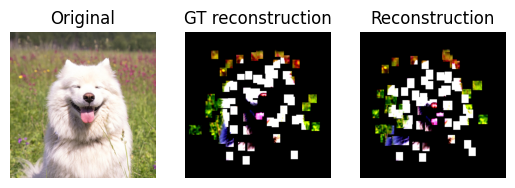

In [ ]:
# from src.utils.visualization.reconstruction_a2 import decoupled_translation_scale_reconstruction_from_crops
# from src.utils.visualization.reconstruction_anchor_reparam import  reconstruction_from_gt_dT_with_anchor
%load_ext autoreload
%autoreload 2
from src.utils.visualization.reconstruction_v4_anchor_reparam import  reconstruction_lstsq_with_anchor_reparam

with torch.no_grad():
    out = model(*batch)

io = clean_model_io(batch, out, 'cuda')

batch_idx = 0
reconstructed_image, g_pos, g_scale, l_pos, l_scale = reconstruction_lstsq_with_anchor_reparam(
        g_crops=io["g_x"][batch_idx],
        l_crops=io["l_x"][batch_idx],
        g_patch_positions=io["g_patch_positions_nopos"][batch_idx],
        l_patch_positions=io["l_patch_positions_nopos"][batch_idx],
        patch_size=16,
        g_shapes=io["g_shapes"],
        l_shapes=io["l_shapes"],
        canonical_img_size=512,
        max_scale_ratio=6.0,
        g_crop_params=io["g_crop_params"][batch_idx],
        l_crop_params=io["l_crop_params"][batch_idx],
        pred_dT=io["pred_dT"][batch_idx],
)

fig, axes = make_plots(reconstructed_image, io, 0, img)
# remove axes
axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")

# fig.suptitle("Reconstruction with LSTSQ (anchor reparametrization)")
fig.show()

In [120]:

# save fig with high dpi
fig.savefig(
    "reconstruction_lstsq_anchor_reparam.png",
    dpi=300,
    bbox_inches="tight",
)

In [111]:
import timm
state_dict = model.state_dict()
state_dict["patch_embed.proj.weight"] = state_dict["patch_embed.proj.weight"].reshape(
    768, 3, 16, 16
)
# filter out 
state_dict = {k: v for k, v in state_dict.items() if not k.startswith("decoder_")}
state_dict.pop("mask_pos_token")
# load pretrained to vit b
vit = timm.create_model("vit_base_patch16_224", pretrained=False)
vit.load_state_dict(state_dict, strict=False)
backbone_state_dict = vit.state_dict()
# remove head
backbone_state_dict.pop("head.weight")
backbone_state_dict.pop("head.bias")
torch.save(
    backbone_state_dict,
    "../../artifacts/model-qjvoibpm:v0/backbone_0049.ckpt",
)

In [112]:
vit = timm.create_model("vit_base_patch16_224", pretrained=False)
vit.load_state_dict(
    torch.load("../../artifacts/model-qjvoibpm:v0/backbone_0049.ckpt"),
    strict=True,
)

RuntimeError: Error(s) in loading state_dict for VisionTransformer:
	Missing key(s) in state_dict: "head.weight", "head.bias". 

NameError: name 'pos' is not defined

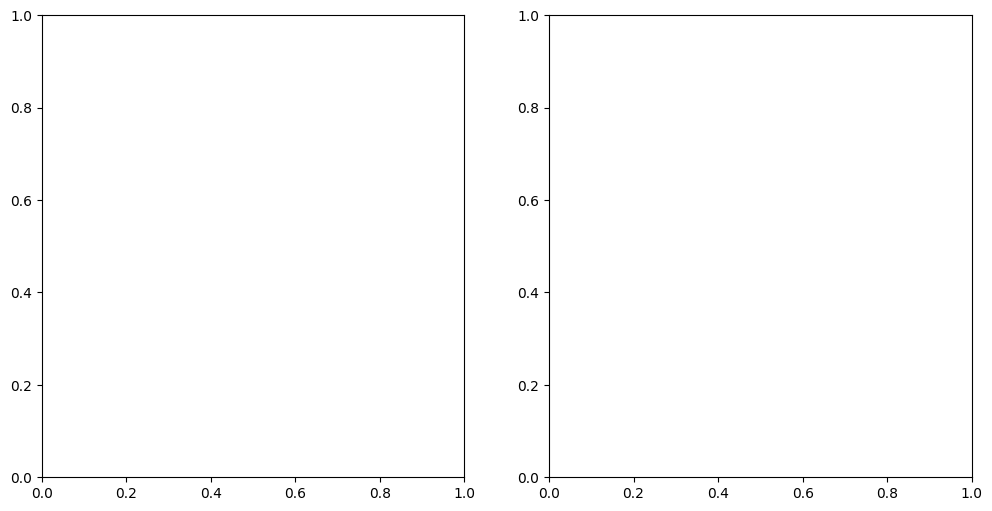

In [ ]:
# plot the positions and scales
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
_pos = torch.stack(pos, dim=0)
_scale = torch.stack(scale, dim=0)
# Plot positions
ax[0].scatter(_pos[:, :, 0], _pos[:, :, 1])
# set range to [0, 512] for both axes
ax[0].set_xlim(0, 512)
ax[0].set_ylim(0, 512)
ax[0].set_title("Optimized Patch Positions")
ax[0].set_xlabel("X Position")
ax[0].set_ylabel("Y Position")

# Plot scales
ax[1].scatter((_scale[:, :, 0]), (_scale[:, :, 1]))
ax[1].set_title("Optimized Patch Scales")
ax[1].set_xlabel("Log Scale (Height)")
ax[1].set_ylabel("Log Scale (Width)")
